In [1]:
USE_DE=True
USE_PE=False
COLAB=False
import os
print(os.getcwd())
import sys
sys.path.append('../src')

/mnt/d/mydev/attention/transformerlab/notebooks


#  Imports

In [2]:
import pathlib
import os
import re
import string
from unicodedata import normalize
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt



from de_data import DataGen
from positional_encoding import encode_pos_sin_cosine, PositionalEmbedding
# from self_attention  import SelfAttention
# from mha import MultiHeadAttention
from add_norm import AddNorm
from positionwise_ff import FeedForward
# from encoder_layer import EncoderLayer
# from transformer_encoder import TransformerEncoder
# from decoder_layer import DecoderLayer
# from transformer_decoder import TransformerDecoder
# from transformer_model import TransformerModel
from lr_schedular import  CustomSchedule, MyCustomSchedule
from masked_loss_accu import loss_function, accuracy_function
from training_loop import start_training



import warnings

# Suppress TensorFlow logging (1=filter INFO, 2=filter INFO and WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Suppress Python warnings
warnings.filterwarnings('ignore')

import time
import random
random.seed(42)
from random import randint
if COLAB:
 from google.colab import drive
if USE_PE:
  import tensorflow_datasets as tfds
  import tensorflow_text
from pathlib import Path
import pathlib
import scipy
import numpy as np
np.random.seed(123)
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Input,  Dense, 
    Concatenate, RepeatVector,
    Lambda, Layer,  Embedding, Bidirectional,
    Dot, LayerNormalization, Dropout)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2024-04-01 15:46:12.644462: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-01 15:46:12.661330: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 15:46:12.663499: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 15:46:12.689413: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 15:46:16.777745: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [3]:
print(tf.__version__)

2.16.1


# Colab or local

In [4]:
if COLAB:
  drive.mount('/content/drive')
  fpath = '/content/drive/My Drive/writeups/notebooks/deu.txt'
  # Check if the file exists
  fpath1 = Path(fpath)
  if fpath1.exists():
      print("File exists.")
  else:
      print("File does not exist.")
else:
  fpath='/mnt/c/Users/Bhujay_ROG/My Drive/writeups/notebooks/deu.txt'

# Generate Data  DE

In [5]:
n_sentences = 500
datagen = DataGen(fpath=fpath)
if USE_DE:
    # datagen = DataGen(fpath='/mnt/c/Users/Bhujay_ROG/My Drive/writeups/notebooks/deu.txt')
    dataset, lang1, lang2 = datagen.get_cleaned_delimited_data_as_array()
    X1, X2, y, lang1_tokenizer, lang2_tokenizer, en_vocab_size, de_vocab_size, en_seq_len, de_seq_len = \
        datagen.get_source_target_data_n_tokenizer(n_sentences=n_sentences, from_end=True)
example_data_x1 = X1[:2]
example_data_x2 = X2[:2]

195847
['Hi.', 'Grüß Gott!']
[INFO] Total dataset size:  (195847, 2)
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[INFO] Total dataset size: 40000
['tom came outside' 'sos tom kam nach drauen eos']
(40000, 2)
(40000,)
tom came outside
195847
['Hi.', 'Grüß Gott!']
[INFO] Total dataset size:  (195847, 2)
[hi] => [hallo]
[hi] => [gru gott]
[run] => [lauf]
[wow] => [potzdonner]
[wow] => [donnerwetter]
[fire] => [feuer]
[help] => [hilfe]
[help] => [zu hulf]
[stop] => [stopp]
[wait] => [warte]
[INFO] Total dataset size: 500
['tom was staring at mary who was sitting on the school bus that was parked in front of the school'
 'sos tom stierte maria an die in dem schulbus sa der vor der schule parkte eos']
(500, 2)
(500,)
tom was staring at mary who was sitting on the school bus that was parked in front of the school
encoder input:
 [[1222 1223    8    1

# Positional Encoding

## PE function

exponent_i:  (512,)
denominator scalar:  512.0
angle_rates: (512,)
angle_rads: (2048, 512)
sine_values_even: (2048, 256)
cosine_values_odd: (2048, 256)
sin_plus_cos_interleaved: (2048, 512)


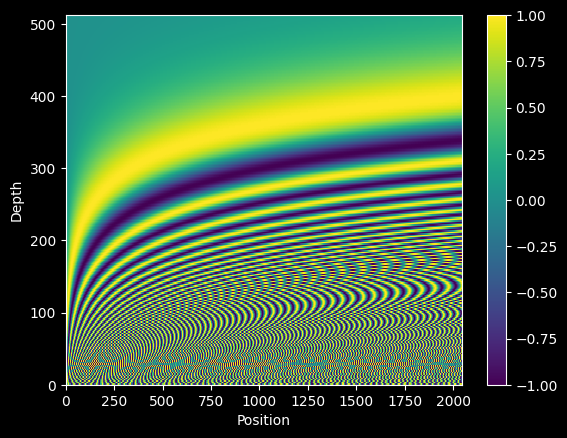

In [6]:
positional_encodings = encode_pos_sin_cosine(2048, 512, debug=True)
plt.style.use('dark_background')
plt.pcolormesh(positional_encodings.T)
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## PE class

In [7]:
d_model=512
pos_embedding = PositionalEmbedding(en_vocab_size, d_model)
embedded_data = pos_embedding(example_data_x1, training=False)
print('embedded_data shape:', embedded_data.shape)
# print('embedded_data shape:', embedded_data[0][3])
print('embedded_data mask', embedded_data._keras_mask)

embedded_data shape: (2, 101, 512)
embedded_data mask tf.Tensor(
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True False False False False False
  False False False False False False False False False False False False
  False False 

# Attention Classes

## Testing MHA masks 

In [8]:
layer = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=2)
x, s = layer(embedded_data, embedded_data, return_attention_scores=True)
print(x)
print(s)

tf.Tensor(
[[[ 2.2337688e-03 -3.0533705e-04  4.7402964e-03 ...  1.1020283e-03
    4.2954083e-03  2.5706599e-03]
  [ 3.4827930e-03 -9.9117879e-04  3.7643488e-03 ...  4.3567145e-04
    3.7247355e-03  1.8140228e-03]
  [ 7.0289511e-04  5.8104109e-04  5.9400499e-03 ...  1.5967219e-03
    5.0847800e-03  3.5944975e-03]
  ...
  [-4.6341377e-03  4.0217698e-02  1.1205485e-02 ...  2.0136762e-02
   -5.2617051e-02  3.1736754e-02]
  [-4.6341377e-03  4.0217698e-02  1.1205485e-02 ...  2.0136762e-02
   -5.2617051e-02  3.1736754e-02]
  [-4.6341377e-03  4.0217698e-02  1.1205485e-02 ...  2.0136762e-02
   -5.2617051e-02  3.1736754e-02]]

 [[-6.1426312e-03  1.7640991e-03 -1.0639527e-02 ... -5.4696817e-03
   -9.1463216e-03 -4.5689931e-03]
  [-1.7985785e-03  6.0630566e-05 -7.7593117e-03 ... -5.2249050e-03
   -5.8432459e-03 -3.6242849e-03]
  [-6.2910700e-03  4.7343338e-04 -1.1724654e-02 ... -5.7852594e-03
   -8.3096940e-03 -6.1029489e-03]
  ...
  [-5.4025771e-03  3.4170981e-02  5.5346829e-03 ...  1.5253182e-02

###  why masked  score of rows are not zero 

considering this elements in the weight matrix  as $w_{11}$ to $w_{nn}$  
and $v_{11}$ to $v_{nd_{v}}$ as the elements in value matrix. 
The result for the first  row of w and first col of the v are this:
$w_{11}v_{11}+w_{12}v_{21}+w_{13}v_{31}+w_{14}v_{41}$ 

$v_{31}$  and $v_{41}$ will be set to zero due to the zero weight $w_{13}$ and $w_{14}$
 



#  Encoder Layer


In [9]:
class EncoderLayerTFmha(Layer):
    def __init__(self, d_model, num_heads, dff,
                 en_dropout=0.1,
                 epsilon=1e-6, debug=False, 
                 use_masked_softmax=False,
                 row_mask_to_sero=False,
                 **kwargs):
        super(EncoderLayerTFmha, self).__init__(**kwargs)
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads, key_dim=d_model,                                        
                                                     )
        self.add_norm1 = AddNorm(epsilon=epsilon)
        self.add_norm2 = AddNorm(epsilon=epsilon)
        self.ffn = FeedForward(d_model, dff)
        self.en_dropout = en_dropout
        self.dropout1 = Dropout(en_dropout)
        self.dropout2 = Dropout(en_dropout)
        self.debug=debug
        self.supports_masking = True  # Declare that this layer supports masking
        self.attention_weights = None

    def call(self, x, training=False, mask=None):
        if self.debug: print('mask received at encoder layer:', mask.shape)
        attn_output  = self.mha(query=x,
                                value=x,
                                key=x, return_attention_scores=False) # Assuming you have implemented MultiHeadAttention        
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.add_norm1(x, attn_output)
        ffn_output = self.ffn(out1)
        # ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.add_norm2(out1, ffn_output)
        self.debug = False
        return out2

#### testing encoder layer

In [10]:
encoder_layer = EncoderLayerTFmha(
    d_model=512, num_heads=8, dff=2048)
print(embedded_data.shape)
en_layer_out = encoder_layer(embedded_data)
print(en_layer_out.shape)

(2, 101, 512)
(2, 101, 512)


# Transformer Encoder

In [11]:
class TransformerEncoderTFmha(Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size,
                 max_pos=2048, epsilon=1e-6,
                 pos_dropout=0.1,
                 en_dropout=0.1,
                 use_masked_softmax=False,
                 row_mask_to_sero=False,
                 debug=False,
                 **kwargs):
        super(TransformerEncoderTFmha, self).__init__(**kwargs)
        self.debug = debug
        # self.en_dropout= en_dropout
        self.num_layers = num_layers
        self.num_heads = num_heads
        # Initialize the PositionalEmbedding layer
        self.positional_embedding = PositionalEmbedding(vocab_size, d_model, max_pos,
                                                        pos_dropout=pos_dropout,
                                                      )
        self.enc_layers_0 = EncoderLayerTFmha(d_model, num_heads, dff, en_dropout, epsilon, 
                                           use_masked_softmax=use_masked_softmax,
                                              row_mask_to_sero=row_mask_to_sero,
                                           debug=debug)
        self.remaining_layers = 0
        if num_layers > 1:
            self.remaining_layers = num_layers - 1
            self.enc_layers = [EncoderLayerTFmha(d_model, num_heads, dff, en_dropout, epsilon, 
                                              use_masked_softmax=use_masked_softmax,
                                              row_mask_to_sero=row_mask_to_sero,
                                              debug=False ) for _ in range(self.remaining_layers)]
        self.supports_masking = True  # Declare that this layer supports masking
        self.attention_weights = None    


    def call(self, x, training, return_attention_weights=False):
        attention_weights = []
        # Apply positional embedding
        x = self.positional_embedding(x, training=training)        
        if self.debug: print('num_heads at encoder call :', self.num_heads)
        
        x = self.enc_layers_0(x, training=training)
        layer_attention_weights = self.enc_layers_0.attention_weights
        self.debug = False
        for i in range(self.remaining_layers):
            x = self.enc_layers[i](x, training=training)
            layer_attention_weights  = self.enc_layers[i].attention_weights
            if return_attention_weights:
                attention_weights.append(layer_attention_weights)
        
        self.attention_weights = attention_weights
        return x

### testing encoder

In [12]:
encoder = TransformerEncoderTFmha(num_layers=1, d_model=512, num_heads=8, 
                  dff=2048, vocab_size=en_vocab_size) 
encoder_out = encoder(X1[:2], training=False)
print('input data:', X1[:2].shape)
print('encoder_out:', encoder_out.shape)

input data: (2, 101)
encoder_out: (2, 101, 512)


# Decoder Layer

In [13]:
class DecoderLayerTFmha(Layer):
    def __init__(self, d_model, num_heads, dff, epsilon=1e-6,
                 de_dropout=0.1, 
                 use_masked_softmax=False,
                 row_mask_to_sero=False,
                 debug=False, **kwargs):
        super(DecoderLayerTFmha, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads, key_dim=d_model,                                        
                                                     )  # Masked self-attention
        self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads, key_dim=d_model,                                        
                                                     )  # Encoder-decoder attention
        self.ffn = FeedForward(d_model, dff)
        self.add_norm1 = AddNorm(epsilon=epsilon)
        self.add_norm2 = AddNorm(epsilon=epsilon)
        self.add_norm3 = AddNorm(epsilon=epsilon)
        self.dropout1 = tf.keras.layers.Dropout(de_dropout)
        self.dropout2 = tf.keras.layers.Dropout(de_dropout)
        self.dropout3 = tf.keras.layers.Dropout(de_dropout)
        self.debug = debug
        self.supports_masking = True  # Declare that this layer supports masking

    def call(self, x, enc_output, training=False, use_causal_mask=True):
        if self.debug: print('start decoder masked multihead :')
        attn1 = self.mha1(x, x, x, use_causal_mask=use_causal_mask )
        # attn_weights_block1 = self.mha1.attention_weights
        attn_weights_block1 = None
        attn1 = self.dropout1(attn1, training=training)
        if self.debug: print('attn1: ', attn1.shape)
        out1 = self.add_norm1(x, attn1)
        if self.debug: print('out1: ', out1.shape)
        if self.debug: print('decoder masked multihead done.\n')
        # Encoder-decoder attention
        if self.debug: print('starting multihead for encoder_out: ')
        ### provide the encoder_mask
        # if self.debug: print('encoder_mask reshaped by decoder:', encoder_mask)
        attn2, attn_weights_block2 = self.mha2(out1, enc_output, enc_output, 
                                               return_attention_scores=True,
                                               use_causal_mask=use_causal_mask)
        # attn_weights_block2 = self.mha2.attention_weights
        attn2 = self.dropout2(attn2, training=training)
        if self.debug: print('attn2: ', attn2.shape)
        out2 = self.add_norm2(out1, attn2)
        if self.debug: print('out2: ', out2.shape)
        # Feedforward
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.add_norm3(out2, ffn_output)
        self.debug = False
        return out3, attn_weights_block1, attn_weights_block2

#### Testing Decoder Layer class

In [14]:
embedded_data_x2 = pos_embedding(X2[:2], training=False)
print('embedded_data_x2:', embedded_data_x2.shape)
decoder_layer = DecoderLayerTFmha(d_model=512, num_heads=8, dff=2048)

decoder_layer_out = decoder_layer(
    embedded_data_x2, encoder_out)

print('embedded_data_x2:',embedded_data_x2.shape)
print('encoder_out:', encoder_out.shape)
print('decoder_layer_out:', decoder_layer_out[0].shape) 

embedded_data_x2: (2, 76, 512)
embedded_data_x2: (2, 76, 512)
encoder_out: (2, 101, 512)
decoder_layer_out: (2, 76, 512)


# Transformer Decoder 

In [15]:
class TransformerDecoderTFmha(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1, debug=False):
    super(TransformerDecoderTFmha, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayerTFmha(d_model=d_model, num_heads=num_heads,
                     dff=dff, de_dropout=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None
    self.debug = debug

    

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)
    if self.debug: print('x:', x.shape)
    if self.debug: print('context:', context.shape)
    for i in range(self.num_layers):      
      x, _, attention_weights  = self.dec_layers[i](x, context)
      self.debug = False
    # The shape of x is (batch_size, target_seq_len, d_model).
    return x, attention_weights

#### Testing Decoder class

In [16]:
decoder = TransformerDecoderTFmha(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=de_vocab_size,
                                 debug=True)
print('X2 data:',X2[:2].shape)
print('encoder_out:', encoder_out.shape)
decoder_out = decoder(
    x=X2[:2], context=encoder_out)

print('decoder_layer_out:', decoder_out[0].shape) 

X2 data: (2, 76)
encoder_out: (2, 101, 512)
x: (2, 76, 512)
context: (2, 101, 512)
decoder_layer_out: (2, 76, 512)


#  Transformer

In [17]:
class TransformerModelTFmha(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size,  target_vocab_size,
                 pe_input, pe_target, pos_dropout=0.1,
                 en_dropout=0.1, de_dropout=0.1,
                 use_masked_softmax=False,
                 row_mask_to_sero=False,
                 debug=False, **kwargs):
        super(TransformerModelTFmha, self).__init__()
        self.num_heads = num_heads
        self.encoder = TransformerEncoderTFmha(num_layers, d_model, num_heads, dff,
                                          input_vocab_size, max_pos=pe_input,
                                         pos_dropout=pos_dropout,
                                         en_dropout=en_dropout,
                                           use_masked_softmax=use_masked_softmax,
                                              row_mask_to_sero=row_mask_to_sero)
        self.decoder = TransformerDecoderTFmha(num_layers, d_model, num_heads, dff,
                                          target_vocab_size, 
                                          # pos_dropout=pos_dropout,
                                          dropout_rate=de_dropout,
                                        # use_masked_softmax=use_masked_softmax,
                                        #       row_mask_to_sero=row_mask_to_sero,
                                          # debug=debug
                                              )
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        self.debug = debug
        self.supports_masking = True  # Declare that this layer supports masking
        self.attention_weights = None

    @tf.function(reduce_retracing=True)
    def call(self, inputs, training=False):
        inp, tar = inputs
        # encoder_mask = x._keras_mask
        # if self.debug: print(f'encoder mask: {encoder_mask}')
        enc_output = self.encoder(inp, training=training)  # (batch_size, inp_seq_len, d_model)
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output,
                                                     training=training)
        self.attention_weights = attention_weights
        logits = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        self.debug = False
        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass
        return logits

    def build(self, input_shape):
      input_shape = list(input_shape)
      super(TransformerModelTFmha, self).build(input_shape)

### Testing Transformer class

In [18]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
transformer = TransformerModelTFmha(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=en_vocab_size,
    target_vocab_size=de_vocab_size,
    pe_input=en_seq_len, pe_target=de_seq_len,
    dropout_rate=dropout_rate)
output = transformer((X1[:2], X2[:2]))

print(X1[:2].shape)
print(X2[:2].shape)
print(output.shape)
idx=2
output = transformer((X1[idx:idx+1], X2[idx:idx+1]))
predicted_id = tf.argmax(output[:, :, :], axis=-1)
print('predicted_id:',  predicted_id)
print()
print('label:', y[idx:idx+1])

(2, 101)
(2, 76)
(2, 76, 2772)
predicted_id: tf.Tensor(
[[ 989 2127 2587 1816  417 1788 2477  775   58 1386  114 1619  129  762
   678  994  601  775  775  775  775  775  775  775  775  775  775  775
   775  775  775  775  775  775  775  775  775  775  775  775  775  775
   775  775  775  775  775  775  775  775  775  775  775  775  775  775
   775  775  775  775  775  775  775  775  775  775  775  775  775  775
   775  775  775  775  775  775]], shape=(1, 76), dtype=int64)

label: [[   3 1031 1032  586    9 1033 1034   35  587   28 1035   17   43   26
  1036 1037 1038    2    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]


In [19]:
attn_scores = transformer.attention_weights
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(None, 8, 76, 101)


In [20]:
transformer.summary()

Model: "transformer_model_t_fmha"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ transformer_encoder_t_fmha_1    │ ?                      │     2,924,032 │
│ (TransformerEncoderTFmha)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_t_fmha_1    │ ?                      │     5,104,640 │
│ (TransformerDecoderTFmha)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │       357,588 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,386,260 (31.99 MB)

 Trainable params: 8,386,260 (31.99 MB)

 Non-trainable params: 0 (0.00 B)

# custom schedular, loss and accuracy 

In [21]:

learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
# optimizer = tf.keras.optimizers.Adam()

#  Parametes

In [22]:
num_layers = 4
d_model = 512
dff = 512
num_heads = 8
dropout_rate = 0.1


#  Data to tensor batches

In [23]:
print(X1[0:1])
print(X2[0:1])
print(y[:1])
X1.shape
type(X1)

[[1222 1223    8    1  157   24 1224 1225  114    1  719 1226   89 1227
     2 1228    8 1229 1230    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]
[[   1 1338 1339   10    8 1340   33   22    3 1341   10   16  684  685
    10   16  208 1342  104 1343    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
[[1338 1339   10    8 1340   33   22    3 1341   10   16  684  685   10
    16  208

numpy.ndarray

In [24]:
if not COLAB:
      model_path= '/mnt/d/MyDev/attention/models'
BATCH_SIZE=64
BUFFER_SIZE = len(X1)  # Assuming X1 and X2 are your dataset
dataset = tf.data.Dataset.from_tensor_slices(((X1, X2), y))
# dataset = dataset.shuffle(
#         BUFFER_SIZE, reshuffle_each_iteration=True).batch(
#         BATCH_SIZE, drop_remainder=True)
# total_batches = (n_sentences) // BATCH_SIZE
# print(total_batches)

# Shuffling the dataset
dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)

# Calculating the number of batches for training and validation
total_batches = len(X1) // BATCH_SIZE
train_batches = int(total_batches * 0.8)
val_batches = total_batches - train_batches

# Splitting the dataset
train_dataset = dataset.take(train_batches * BATCH_SIZE)
val_dataset = dataset.skip(train_batches * BATCH_SIZE)

# Batching the datasets
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

print(f"Total batches: {total_batches}")
print(f"Training batches: {train_batches}")
print(f"Validation batches: {val_batches}")

Total batches: 7
Training batches: 5
Validation batches: 2


# Train

In [29]:
trained_transformer = TransformerModelTFmha(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=en_vocab_size,
    target_vocab_size=de_vocab_size,
    pe_input=en_seq_len, pe_target=de_seq_len,
    dropout_rate=dropout_rate)
trained_transformer.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=[accuracy_function])
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')

In [30]:
trained_transformer.fit(train_dataset,
                epochs=20,
                validation_data=val_dataset,
                        callbacks=[early_stopping]
               )

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 70s 12s/step - accuracy_function: 7.1961e-04 - loss: 8.0785 - val_accuracy_function: 3.9002e-04 - val_loss: 8.0603
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 55s 11s/step - accuracy_function: 3.5789e-04 - loss: 8.0677 - val_accuracy_function: 0.0000e+00 - val_loss: 8.0041
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 1.7506e-04 - loss: 8.0100 - val_accuracy_function: 3.8640e-04 - val_loss: 7.9324
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.0037 - loss: 7.9140 - val_accuracy_function: 0.0217 - val_loss: 7.8015
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.0206 - loss: 7.8135 - val_accuracy_function: 0.0536 - val_loss: 7.6525
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.0506 - loss: 7.6800 - val_accuracy_function: 0.0616 - val_loss: 7.4876
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.0606 - loss: 7.5362 - val_accuracy_function: 0

In [31]:
trained_transformer.fit(train_dataset,
                epochs=12,
                validation_data=val_dataset,
                        callbacks=[early_stopping]
               )

Epoch 1/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.0824 - loss: 6.6258 - val_accuracy_function: 0.0872 - val_loss: 6.4930
Epoch 2/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.0843 - loss: 6.5783 - val_accuracy_function: 0.0894 - val_loss: 6.4361
Epoch 3/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.0871 - loss: 6.5163 - val_accuracy_function: 0.0956 - val_loss: 6.3319
Epoch 4/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.0887 - loss: 6.4612 - val_accuracy_function: 0.1020 - val_loss: 6.3245
Epoch 5/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.0956 - loss: 6.3772 - val_accuracy_function: 0.1133 - val_loss: 6.2831
Epoch 6/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.1039 - loss: 6.2914 - val_accuracy_function: 0.1213 - val_loss: 6.1630
Epoch 7/12
5/5 ━━━━━━━━━━━━━━━━━━━━ 55s 11s/step - accuracy_function: 0.1140 - loss: 6.2492 - val_accuracy_function: 0.1136 - val_loss: 6.2141

In [32]:
trained_transformer.fit(train_dataset,
                epochs=25,
                validation_data=val_dataset,
                        callbacks=[early_stopping]
               )

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 55s 11s/step - accuracy_function: 0.1390 - loss: 5.9515 - val_accuracy_function: 0.1588 - val_loss: 5.7438
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.1491 - loss: 5.8342 - val_accuracy_function: 0.1596 - val_loss: 5.6863
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.1486 - loss: 5.7845 - val_accuracy_function: 0.1750 - val_loss: 5.4797
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.1596 - loss: 5.7128 - val_accuracy_function: 0.1781 - val_loss: 5.4661
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.1684 - loss: 5.6119 - val_accuracy_function: 0.1797 - val_loss: 5.4229
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.1713 - loss: 5.5544 - val_accuracy_function: 0.1951 - val_loss: 5.3380
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.1764 - loss: 5.4788 - val_accuracy_function: 0.1902 - val_loss: 5.2609

In [33]:
trained_transformer.fit(train_dataset,
                epochs=50,
                validation_data=val_dataset,
                        callbacks=[early_stopping]
               )

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.3518 - loss: 3.9542 - val_accuracy_function: 0.4096 - val_loss: 3.4532
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.3647 - loss: 3.8733 - val_accuracy_function: 0.4344 - val_loss: 3.3092
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.3876 - loss: 3.7582 - val_accuracy_function: 0.4515 - val_loss: 3.1929
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.3911 - loss: 3.6794 - val_accuracy_function: 0.4547 - val_loss: 3.1785
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.4139 - loss: 3.5674 - val_accuracy_function: 0.4619 - val_loss: 3.0887
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.4196 - loss: 3.5442 - val_accuracy_function: 0.5014 - val_loss: 2.9256
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 11s/step - accuracy_function: 0.4276 - loss: 3.4482 - val_accuracy_function: 0.5212 - val_loss: 2.8874

In [ ]:
# trained_transformer.fit(train_dataset,
#                 epochs=200,
#                 validation_data=val_dataset,
#                         callbacks=[early_stopping]
#                )

# Checked traied Model

In [ ]:
idx=1
output = trained_transformer((X1[idx:idx+1], X2[idx:idx+1]))
predicted_id = tf.argmax(output, axis=-1)
print('predicted_id:',  predicted_id)
print()
print('label:', y[idx:idx+1])

# saving the trained model 

In [42]:
import pickle
fit_model = trained_transformer
if not COLAB:
      model_path= '/mnt/d/MyDev/attention/models'
model_full_name = os.path.join(model_path, 'TFMHAOnly_500Long_92acc_Wip.weights.h5')
trained_transformer.save_weights(model_full_name)
with open(model_path + '/config.pkl', 'wb') as config_file:
        pickle.dump(trained_transformer.get_config(), config_file)
with open(model_path + '/config.pkl', 'rb') as config_file:
        fit_model_config = pickle.load(config_file)
loaded_fit_model = TransformerModelTFmha(num_layers,
                                   d_model,
                                   num_heads, dff,
                                   en_vocab_size,
                                   de_vocab_size,
                                   en_seq_len,
                                   de_seq_len,                                   
                                   debug=False)
loaded_model = loaded_fit_model_out
loaded_fit_model_out = loaded_fit_model((X1[:2], X2[:2]), training=False)
loaded_fit_model.load_weights(model_full_name)
print(fit_model.summary())
print(loaded_fit_model.summary())

Model: "transformer_model_t_fmha_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ transformer_encoder_t_fmha_4    │ ?                      │    36,855,808 │
│ (TransformerEncoderTFmha)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_t_fmha_3    │ ?                      │    70,744,064 │
│ (TransformerDecoderTFmha)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ ?                      │     1,422,036 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 327,065,725 (1.22 GB)

 Trainable params: 109,021,908 (415.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 218,043,817 (831.77 MB)

None


Model: "transformer_model_t_fmha_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ transformer_encoder_t_fmha_8    │ ?                      │    36,855,808 │
│ (TransformerEncoderTFmha)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_t_fmha_7    │ ?                      │    70,744,064 │
│ (TransformerDecoderTFmha)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ ?                      │     1,422,036 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,021,908 (415.89 MB)

 Trainable params: 109,021,908 (415.89 MB)

 Non-trainable params: 0 (0.00 B)

None


In [44]:
### trained model from memory 
tf.config.run_functions_eagerly(True)
idx=4
output = fit_model((X1[idx:idx+1], X2[idx:idx+1]), training=False)
predicted_id = np.argmax(output, axis=-1)
print('predicted_id:\n',  predicted_id)
print('label:\n', y[idx:idx+1])

predicted_id:
 [[  91    6   53   86 1428 1429 1430   46   32    6  299 1431    9    6
    15  258 1432   10   13 1433  196  146   38    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2]]
label:
 [[  91    6   53   86 1428 1429 1430   46   32    6  299 1431    9    6
    15  258 1432   10   13 1433  196  146   38    2    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]


In [ ]:
# model_full_name = os.path.join(model_path, 'tftutoral_l4_dm128_dff512_h8_acc92')
# tf.saved_model.save(transformer, export_dir=model_full_name)
# loaded_model = tf.saved_model.load(model_full_name)  ''' DID NOT WORK '''

# Attention Score display 

### get scores from the  trained model

In [45]:
trained_transformer.attention_weights

<tf.Tensor: shape=(1, 8, 76, 101), dtype=float32, numpy=
array([[[[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [7.0986524e-03, 9.9290127e-01, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [6.2781660e-06, 8.2358068e-01, 1.7641303e-01, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [9.9009899e-03, 9.9009899e-03, 9.9009899e-03, ...,
          9.9009899e-03, 9.9009899e-03, 9.9009899e-03],
         [9.9009899e-03, 9.9009899e-03, 9.9009899e-03, ...,
          9.9009899e-03, 9.9009899e-03, 9.9009899e-03],
         [9.9009899e-03, 9.9009899e-03, 9.9009899e-03, ...,
          9.9009899e-03, 9.9009899e-03, 9.9009899e-03]],

        [[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [3.7436985e-07, 9.9999964e-01, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],

In [ ]:
attention_weights = trained_transformer.decoder.last_attn_scores
print(attention_weights.shape)  # (batch, heads, target_seq, input_seq)
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[0]
ax = plt.gca()
ax.matshow(attention)

In [ ]:
trained_transformer((X1[:1], X2[:1]), training=False)

In [ ]:
attn_scores = trained_transformer.decoder.last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

### Plot Functions

####  Plot function

In [46]:
def id_to_token_in_vocab(ids, tokenizer=lang1_tokenizer):
    # Convert a single ID to a sequence by wrapping it in a list of lists
    sequences = [[id] for id in ids]
    # Use sequences_to_texts to convert these sequences back to text
    texts = tokenizer.sequences_to_texts(sequences)
    # sequences_to_texts returns a list of text strings
    return texts

def id_to_token_out_vocab(ids, tokenizer=lang2_tokenizer):
    sequences = [[id] for id in ids]
    texts = tokenizer.sequences_to_texts(sequences)
    return texts


def plot_attention_weights(encoder_input, decoder_input,
                           attention_weights, layer=None,
                           lang1_tokenizer=lang1_tokenizer,
                           lang2_tokenizer=lang2_tokenizer,
                          figsize=(12, 15),
                          nrows=2, ncols=4):
    # Assuming 'attention_weights[layer]' is of shape (num_heads, seq_len_decoder, seq_len_encoder)
    num_heads = attention_weights.shape[0]   #attention_weights[layer].shape[0]
    seq_len_decoder = attention_weights.shape[1]  ### attention_weights[layer].shape[1]
    seq_len_encoder = attention_weights.shape[2]

    # Set up the matplotlib figure and axes, based on the number of heads
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=figsize)

    # If there's only one head, matplotlib doesn't return an array of axes
    if num_heads == 1:
        axes = np.array([axes])

    encoder_input_tokens = id_to_token_in_vocab(encoder_input[0], lang1_tokenizer)
    decoder_input_tokens = id_to_token_out_vocab(decoder_input[0], lang2_tokenizer)

    # Flatten the list of tokens if they are returned as list of lists
    encoder_input_tokens = [token for sublist in encoder_input_tokens for token in sublist.split()]
    decoder_input_tokens = [token for sublist in decoder_input_tokens for token in sublist.split()]
    len_en_token = len(encoder_input_tokens)
    len_de_token = len(decoder_input_tokens)
    for head, ax in zip(range(num_heads), axes.flatten()):
        # ax = axes[head]
        # attention_head_weights = attention_weights[layer][head]
        # print('head:', head)
        attention_head_weights = attention_weights[head]
        # print('attention_head_weights:', attention_head_weights.shape)
        cax = ax.matshow(attention_head_weights[:len_de_token, :len_en_token], cmap='viridis')

        ax.set_xticks(range(len(encoder_input_tokens)))
        ax.set_yticks(range(len(decoder_input_tokens[1:])))

        ax.set_xticklabels(encoder_input_tokens, rotation=90)
        ax.set_yticklabels(decoder_input_tokens[1:])

        ax.set_title(f'Head {head+1}')

    # plt.colorbar(cax, ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
    plt.tight_layout()
    plt.show()


####  show plot function

### function show_plot

90
sample_decoder_input: [[  1  42 123  59 834  43  47  13 117   5  32   7  75  14  51 304  38  15
   59 143  37 259   4  69   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]
prediction_out: (1, 76, 2772)
predicted_id: [[ 42 400  59 834  43  47  13 117   5  32   7  75  14  51 304  38  15  59
  143  37 259   4  69   2   2   2   2   2   2   2   2   2   2   2   2   2
    2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
    2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
    2   2   2   2]]
predicted label: [[ 42 123  59 834  43  47  13 117   5  32   7  75  14  51 304  38  15  59
  143  37 259   4  69   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   

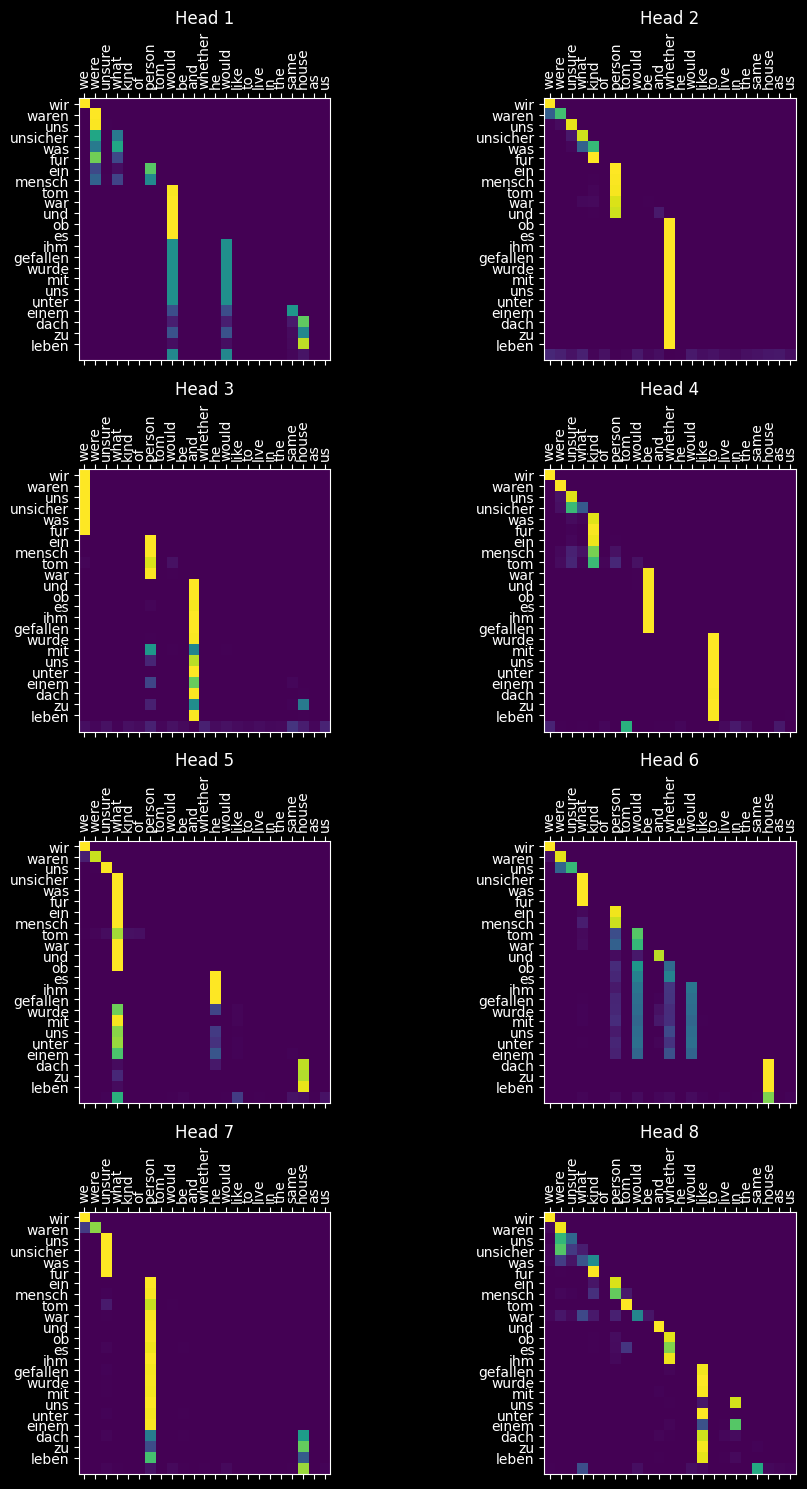

In [48]:
def show_plot(start=1, end=110, n=1,  ####sample_decoder_input[:,:-1]
             layer='decoder_layer5_block2',
             figsize=(12, 15),
                          nrows=2, ncols=4):
    random_integers = [random.randint(start, end) for _ in range(n)]
    for n in random_integers:
        print(n)
        sample_encoder_input = X1[n:n+1]  # Select a sample input
        sample_decoder_input = X2[n:n+1] ###[:,:-1]  # Select a corresponding target input
        print('sample_decoder_input:', sample_decoder_input)
        prediction_out = trained_transformer([sample_encoder_input, sample_decoder_input], training=False)
        print('prediction_out:', prediction_out.shape)
        predicted_id = tf.argmax(prediction_out, axis=-1)
        print('predicted_id:', predicted_id.numpy())
        print('predicted label:', y[n:n+1])
        # layer = list(transformer_weights.keys())[-1]
        attention_weights_n = trained_transformer.attention_weights
        attention_weights_n = tf.squeeze(attention_weights_n, axis=0)
        print('attn_scores: ' , attention_weights_n.shape)
        plot_attention_weights(sample_encoder_input, sample_decoder_input, attention_weights_n,
                              figsize=figsize, nrows=nrows, ncols=ncols)
show_plot(n=1, figsize=(10, 15),
                          nrows=4, ncols=2)

###  display plots

394
sample_decoder_input: [[   1   63  111 1992    6   15  372  111   19   17   26 1993   27    6
   813  108   34  372  111   61   41   34  372  111    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
prediction_out: (1, 76, 2772)
predicted_id: [[  63  111 1992    6   15  372  111   19   17   26 1993   27    6   41
   108   34  372  111   61   41   34  372  111   61    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2    2    2    2    2    2    2    2    2
     2    2    2    2    2    2]]
predicted label: [[  63  111 1992    6   15  372  111   19   17   26 1993   27    6  813
   108   34  372  111   61   41   34  372  111    2  

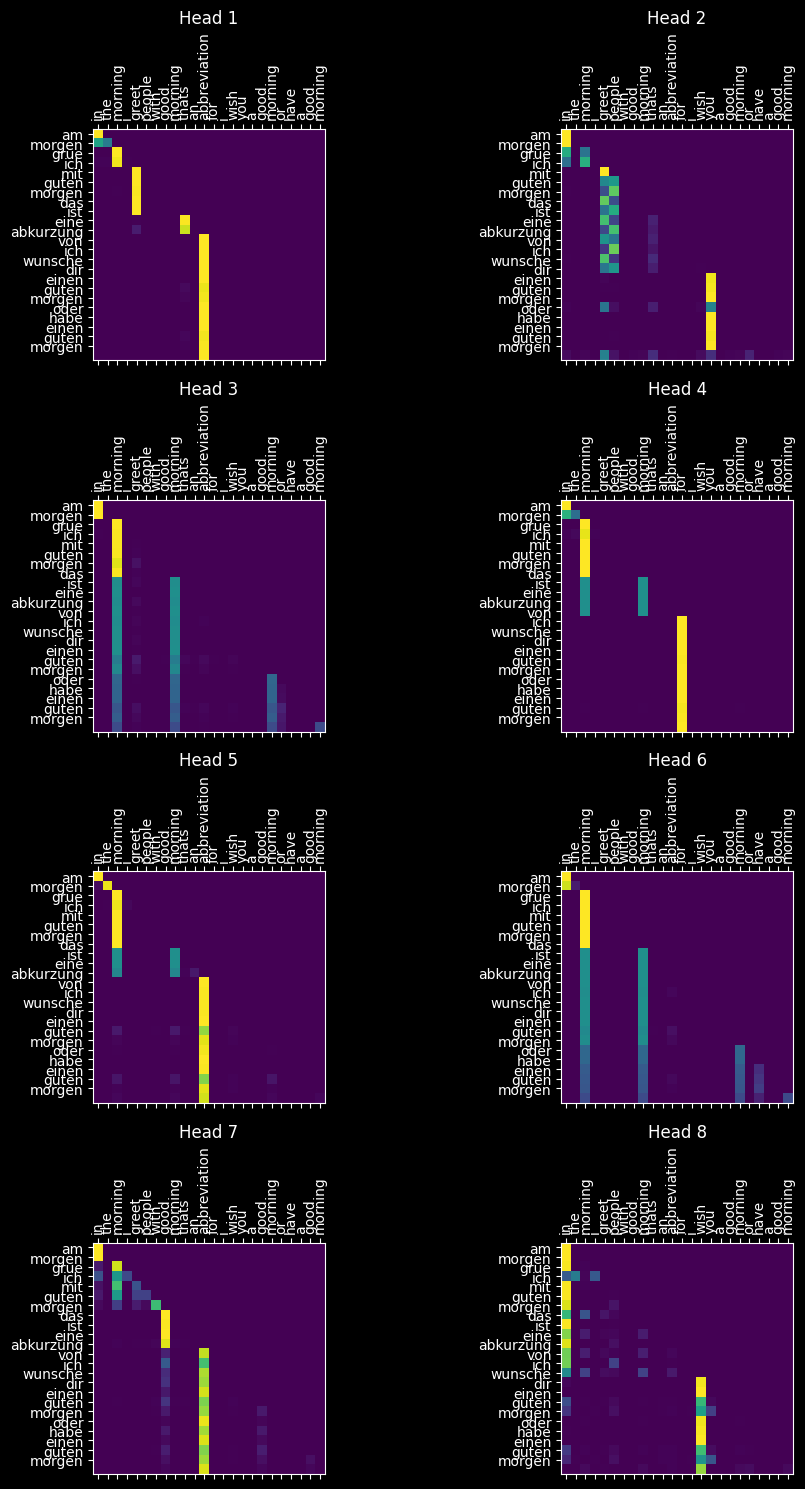

In [49]:
show_plot(n=1, start=1, end=999, figsize=(10, 15),
                          nrows=4, ncols=2)

# Translator

In [50]:
input_raw_text = lang1_tokenizer.sequences_to_texts(X1[0:1])[0]
print('input_raw_text:', input_raw_text)
label = lang2_tokenizer.sequences_to_texts(y[0:1])[0]
print('label:', label)

input_raw_text: corn yields in the us have increased fivefold over the past seventy years thanks to advances in agricultural technology
label: dank fortschritten in der agrartechnik hat sich die maisernte in den vereinigten staaten in den letzten siebzig jahren verfunffacht eos


### Translator Function

In [54]:
class Translator(tf.Module):
    def __init__(self, lang1_tokenizer, lang2_tokenizer, transformer):
        self.lang1_tokenizer = lang1_tokenizer
        self.lang2_tokenizer = lang2_tokenizer
        self.transformer = transformer
        self.attention_weight = None

    def __call__(self, sentence, max_length=40):
        # Tokenize the input sentence
        sentence = self.tokenize_texts(sentence, self.lang1_tokenizer)
        encoder_input = tf.convert_to_tensor(sentence)
        
        # Initialize the output sequence with the start token
        start_seq = self.lang2_tokenizer.texts_to_sequences(['sos'])[0]  ### only single token
        start_seq = tf.cast(start_seq, dtype=tf.int64)
        start_seq = tf.expand_dims(start_seq, 0)  # Ensure shape is (1, 1) = > batch, single_seq
        
        # Dynamic sequence generation
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, start_seq)
        for i in tf.range(max_length):
            output_seq = tf.transpose(output_array.stack(), perm=[1, 0, 2])
            output_seq = tf.reshape(output_seq, [1, -1])
            predictions = self.transformer([encoder_input, output_seq], training=False)
            
            # Select the last token from the seq_len dimension
            predicted_id = tf.argmax(predictions[:, -1, :], axis=-1)
            predicted_id = tf.expand_dims(predicted_id, 1)  # Expand dims to match shape (1, 1)
            output_array = output_array.write(i+1, predicted_id)
            
            # Check if the last predicted token is the end token
            if tf.reduce_all(predicted_id == self.lang2_tokenizer.word_index['eos']):
                break
                
        output = tf.transpose(output_array.stack())
        output = tf.reshape(output, [1, -1])  # Reshape to flatten the sequence
        # Convert token IDs back to text
        translated_sequence = self.detokenize_texts(output, self.lang2_tokenizer)
        self.attention_weights = self.transformer.attention_weights
        # decoder.dec_layers[-1].last_attn_scores
        return translated_sequence

    @staticmethod
    def tokenize_texts(text, tokenizer):
        # Tokenize the text using the tokenizer's texts_to_sequences method
        tokenized_text = tokenizer.texts_to_sequences([text])
        return tf.keras.preprocessing.sequence.pad_sequences(tokenized_text, padding='post')

    @staticmethod
    def detokenize_texts(sequence, tokenizer):
        # Convert the sequence of token IDs back to text using the tokenizer's sequences_to_texts method
        text = tokenizer.sequences_to_texts(sequence.numpy().tolist())
        return text


# Assuming transformer is your Transformer model instance
translator = Translator(lang1_tokenizer, lang2_tokenizer, trained_transformer)
print('input_raw_text:', input_raw_text)
translated_text = translator(input_raw_text, max_length=50)
print(translated_text)
print('label:', label)

input_raw_text: corn yields in the us have increased fivefold over the past seventy years thanks to advances in agricultural technology
['sos dank fortschritten in der agrartechnik hat sich die maisernte in den vereinigten staaten in den letzten siebzig jahren verfunffacht eos']
label: tom duscht lieber am morgen wahrend maria lieber vor dem zubettgehen badet eos


### Testing Translator

In [52]:
idx = 10
input_raw_text1 = lang1_tokenizer.sequences_to_texts(X1[idx:idx+1])[0]
print('input_raw_text1:', input_raw_text1)
label = lang2_tokenizer.sequences_to_texts(y[idx:idx+1])[0]
print('label:', label)
translated_text = translator(input_raw_text1, max_length=50)
print()
print(translated_text)

input_raw_text1: tom prefers to take a shower in the morning while mary prefers to take a bath just before going to bed
label: tom duscht lieber am morgen wahrend maria lieber vor dem zubettgehen badet eos

['sos tom duscht lieber am morgen wahrend maria lieber vor dem zubettgehen badet eos']


In [55]:
attention_weights_n = tf.squeeze(translator.attention_weights, 0)

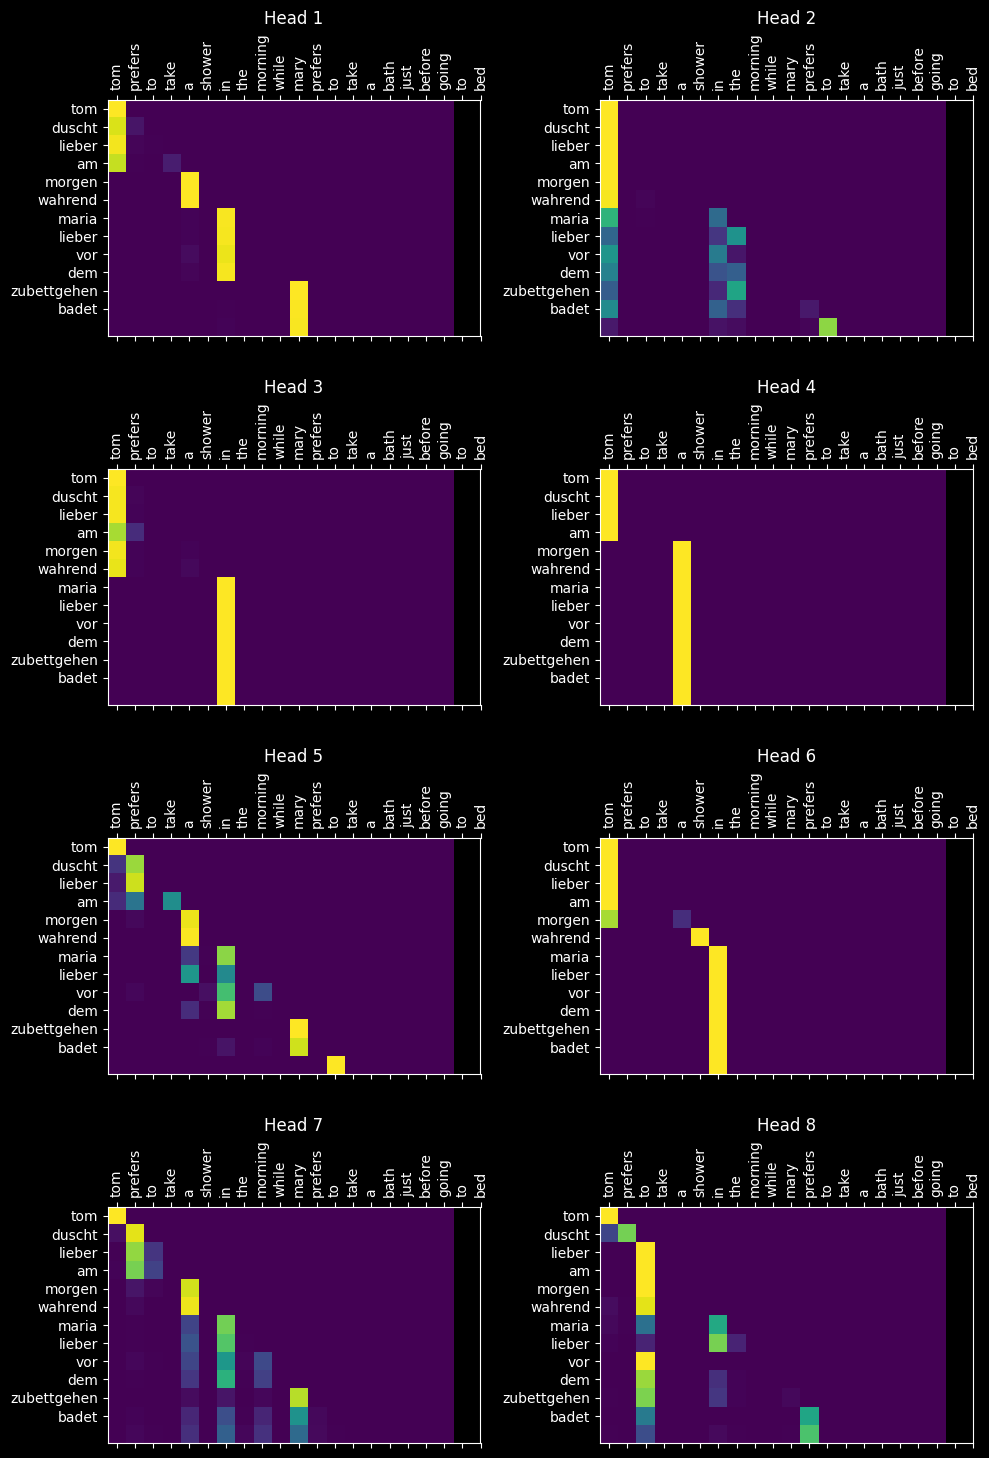

In [56]:
plot_attention_weights(X1[idx:idx+1], X2[idx:idx+1],
                           attention_weights_n, figsize=(10, 15),
                          nrows=4, ncols=2)

In [ ]:
lang2_tokenizer.texts_to_sequences(['eos'])

In [ ]:
lang1_tokenizer.sequences_to_texts(X1[:1])

In [ ]:
# predictions = translator(tf.constant(X1[:1]))